In [1]:
# cell 0 — runtime check (GPU expected: A100)
import os, platform, torch, psutil
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"
print("Python:", platform.python_version())
print("CUDA available:", torch.cuda.is_available())
if not torch.cuda.is_available():
    raise SystemError("GPU not found. Set Runtime -> A100 GPU and re-run.")
print("GPU:", torch.cuda.get_device_name(0))
print("RAM GB:", round(psutil.virtual_memory().total/2**30, 2))

Python: 3.12.12
CUDA available: True
GPU: NVIDIA A100-SXM4-80GB
RAM GB: 167.05


In [2]:
# cell 1 — install deps
!pip -q install --upgrade transformers accelerate datasets sentencepiece huggingface_hub faiss-cpu
!pip -q install --upgrade vllm bitsandbytes || echo "Install note: vLLM/bitsandbytes fallback if unavailable."

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 121.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 57.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.9/87.9 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 466.5/466.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 355.0/355.0 kB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.0/183.0 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 135.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 129.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2

In [3]:
# cell 2 — clone repo + demo Wikipedia subset (~9 GB)
%cd /content
!git clone -q https://github.com/AkariAsai/self-rag.git
%cd /content/self-rag/retrieval_lm
!bash download_demo_corpus.sh
%cd /content

/content
/content/self-rag/retrieval_lm
Downloading...
From (original): https://drive.google.com/uc?id=1IYNAkwawfCDiBL27BlBqGssxFQH9vOux
From (redirected): https://drive.google.com/uc?id=1IYNAkwawfCDiBL27BlBqGssxFQH9vOux&confirm=t&uuid=0e804639-942e-44b9-8a98-c79144b80f19
To: /content/self-rag/retrieval_lm/enwiki_2020_intro_only.zip
100% 9.65G/9.65G [02:20<00:00, 68.7MB/s]
Archive:  enwiki_2020_intro_only.zip
   creating: enwiki_2020_intro_only/
   creating: enwiki_2020_intro_only/enwiki_dec_2020_contriever_intro/
  inflating: enwiki_2020_intro_only/enwiki_dec_2020_contriever_intro/passages_03  
  inflating: enwiki_2020_intro_only/enwiki_dec_2020_contriever_intro/passages_00  
  inflating: enwiki_2020_intro_only/enwiki_dec_2020_contriever_intro/passages_02  
  inflating: enwiki_2020_intro_only/enwiki_dec_2020_contriever_intro/passages_01  
  inflating: enwiki_2020_intro_only/enwiki_2020_dec_intro_only.jsonl  
/content


In [4]:
# cell 3 — retriever (CPU, FAISS)
%cd /content/self-rag/retrieval_lm
import os, sys
sys.path.insert(0, os.getcwd())  # make local 'src' importable
from passage_retrieval import Retriever

RETRIEVER_MODEL = "facebook/contriever-msmarco"
CORPUS_JSONL    = "enwiki_2020_intro_only/enwiki_2020_dec_intro_only.jsonl"
EMB_GLOB        = "enwiki_2020_intro_only/enwiki_dec_2020_contriever_intro/*"

retriever = Retriever({"device": "cpu"})  # keep VRAM for LLM
retriever.setup_retriever_demo(
    RETRIEVER_MODEL, CORPUS_JSONL, EMB_GLOB,
    n_docs=5, save_or_load_index=False
)

def retrieve_paragraphs(query, k=5, max_chars=1400):
    docs = retriever.search_document_demo(query, k)
    return [{"title": d["title"], "text": (d["text"] or "")[:max_chars]} for d in docs]

%cd /content

/content/self-rag/retrieval_lm
Loading model from: facebook/contriever-msmarco


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/619 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/321 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/contriever-msmarco were not used when initializing Contriever: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing Contriever from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Contriever from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Indexing passages from files ['enwiki_2020_intro_only/enwiki_dec_2020_contriever_intro/passages_00', 'enwiki_2020_intro_only/enwiki_dec_2020_contriever_intro/passages_01', 'enwiki_2020_intro_only/enwiki_dec_2020_contriever_intro/passages_02', 'enwiki_2020_intro_only/enwiki_dec_2020_contriever_intro/passages_03']
Loading file enwiki_2020_intro_only/enwiki_dec_2020_contriever_intro/passages_00


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Total data indexed 1000000
Loading file enwiki_2020_intro_only/enwiki_dec_2020_contriever_intro/passages_01
Total data indexed 2000000
Total data indexed 3000000
Loading file enwiki_2020_intro_only/enwiki_dec_2020_contriever_intro/passages_02
Total data indexed 4000000
Loading file enwiki_2020_intro_only/enwiki_dec_2020_contriever_intro/passages_03
Total data indexed 5000000
Total data indexed 6000000
Total data indexed 6088770
Data indexing completed.
Indexing time: 52.9 s.
loading passages
passages have been loaded
/content


In [5]:
# cell 4 — load SELF-RAG 7B via vLLM (clean)
import os
os.environ.setdefault("VLLM_WORKER_MULTIPROC_METHOD", "spawn")
os.environ.setdefault("VLLM_LOGGING_LEVEL", "WARNING")

from vllm import LLM, SamplingParams

MODEL_NAME = "selfrag/selfrag_llama2_7b"
llm = LLM(
    MODEL_NAME,
    dtype="half",
    tensor_parallel_size=1,
    gpu_memory_utilization=0.88,  # lower if VRAM is tight
    trust_remote_code=False,
)
sampling = SamplingParams(
    temperature=0.0, top_p=1.0, max_tokens=300, skip_special_tokens=False
)

def llm_generate(prompts):
    outs = llm.generate(prompts, sampling)
    return [o.outputs[0].text for o in outs]

print("Backend: vLLM fp16")

config.json:   0%|          | 0.00/635 [00:00<?, ?B/s]

WARNING 12-11 21:15:20 [arg_utils.py:1175] `seed=None` is equivalent to `seed=0` in V1 Engine. You will no longer be allowed to pass `None` in v0.13.
WARNING 12-11 21:15:40 [model.py:2089] Casting torch.bfloat16 to torch.float16.


tokenizer_config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/433 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/470 [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

Backend: vLLM fp16


In [6]:
# cell 5 — prompt helpers
import re

# -----------------------------
# SMART RETRIEVAL DECISION LOGIC
# -----------------------------
SMART_RETRIEVAL_POLICY = """
You are a retrieval controller.

Decide whether the question requires retrieval:
- If the answer depends on factual recall (dates, people, events, awards, definitions of specific entities) → RESPOND "RETRIEVE"
- If the question is conceptual (explain, why, compare, contrast, child-friendly explanation, math reasoning) → RESPOND "NO_RETRIEVE"
- If the question concerns recent events (after 2020) → RESPOND "RETRIEVE"
- If not sure → RESPOND "RETRIEVE"

Respond with exactly one token:
RETRIEVE
or
NO_RETRIEVE
"""

def decide_retrieval(query):
    prompt = f"{SMART_RETRIEVAL_POLICY}\n\nQuestion: {query}\nResponse:"
    out = llm_generate([prompt])[0].strip().upper()
    return out.startswith("RETRIEVE")


# ----------------------------------------
# STRUCTURED BUT MINIMAL ANSWER TEMPLATE
# ----------------------------------------
STRUCTURED_HEADER = """
Use ONLY the retrieved context.
If the context does not contain the needed information, respond EXACTLY with:
"I don't know."

Format:
1. Evidence Summary (1–2 sentences)
2. Final Answer (must cite at least one [TITLE])
"""

def build_answer_prompt(query, paragraph):
    return f"""
### Instruction:
{STRUCTURED_HEADER}

### Context:
{paragraph}

### Question:
{query}

### Response:
"""


# ----------------------------------------
# format_prompt() — for first pass + retrieval
# ----------------------------------------
def format_prompt(query, paragraph=None):
    """
    Pass 1:
        - Decide whether retrieval is needed.
    Pass 2:
        - If retrieval needed → return grounded answer template.
        - If not → answer directly.
    """
    if paragraph is None:
        # Retrieval decision phase with few-shot guidance
        return f"""
### Instruction:
Determine if retrieval is needed using the rules below.

{SMART_RETRIEVAL_POLICY}

### Question:
{query}

### Response:
"""
    else:
        return build_answer_prompt(query, paragraph)


In [7]:
# cell 6 — end-to-end ask() with on-demand retrieval over demo Wikipedia
def ask(query, k=5, show_docs=2):
    # Pass 1: see if model opts to retrieve
    first = llm_generate([format_prompt(query)])[0]
    needs = ("[Retrieval]" in first) or ("[Retrieve]" in first)
    print("First pass:\n", first.strip(), "\n")
    if not needs:
        return {"answer": first.strip(), "used_retrieval": False}

    # Retrieve and score candidates
    docs = retrieve_paragraphs(query, k=k)
    prompts = [format_prompt(query, f'{d["title"]}\n{d["text"]}') for d in docs]
    outs = llm_generate(prompts)
    cands = [{"doc": docs[i], "output": outs[i]} for i in range(len(docs))]
    best = best_by_utility(cands)

    print("Top evidence:")
    for d in docs[:show_docs]:
        print("-", d["title"])
    print("\nFinal answer:\n", best["output"].strip())
    return {
        "answer": best["output"].strip(),
        "used_retrieval": True,
        "evidence_titles": [d["title"] for d in docs]
    }


In [8]:
# cell 7 — test scaffolding helpers (non-invasive)
import textwrap as _tw

def _preview(text, n=300):
    t = (text or "").strip().replace("\n", " ")
    return (t[:n] + ("..." if len(t) > n else ""))

In [9]:
# cell 8 — quick KB checks
_docs = retrieve_paragraphs("machine learning", k=3)
print("KB sample titles:", [d["title"] for d in _docs])

Questions embeddings shape: torch.Size([1, 768])


100%|██████████| 1/1 [00:01<00:00,  1.72s/it]

Search time: 1.7 s.
KB sample titles: ['Machine learning', 'Machine Learning (journal)', 'Outline of machine learning']


In [10]:
# cell 9 — Self-Critique + Refinement Layer (Step 3 of SELF-RAG)
# Uses the SAME retriever (KB) for prompt construction.

import textwrap

def build_prompt(query: str, mode: str = "qa", retrieved_docs=None) -> str:
    """
    Build grounded prompt using minimal structure.
    """
    retrieved_docs = retrieved_docs or []
    ctx = "\n\n".join(
        [f"[TITLE] {d['title']}\n[TEXT]\n{d['text']}" for d in retrieved_docs]
    )

    mode_header = {
        "qa": "Answer using ONLY context.",
        "compare_contrast": "Compare and contrast USING ONLY context.",
        "chain_of_thought": "Explain step-by-step USING ONLY context (but hide reasoning).",
        "explanatory": "Explain clearly using ONLY context."
    }.get(mode, "Answer using ONLY context.")

    return f"""
### System:
{mode_header}

Your response MUST follow:

1. Evidence Summary (1–2 sentences)
2. Final Answer (cite one [TITLE])
If context is insufficient, output EXACTLY: "I don't know."

### Context:
{ctx if ctx else "[NO CONTEXT]"}

### Question:
{query}

### Response:
"""

def critique_prompt(query: str, initial_answer: str) -> str:
    """
    Minimalistic critique: improves answer without over-rewriting.
    """
    return f"""
### Instruction:
You will revise your previous answer.

Check for:
- Hallucination (info not in context)
- Missing citation
- Incorrect or incomplete reasoning

Output:
1. One-sentence critique
2. Refined Answer (only modify incorrect parts; keep correct parts unchanged)
3. "Changes made: <short summary>"

### Question:
{query}

### Previous Answer:
{initial_answer}

### Response:
"""


def ask_with_prompt(query, mode="qa", k=5):
    """
    SELF-RAG retrieval + LLM with engineered prompt.
    Always retrieves from the SAME KB.
    """
    docs = retrieve_paragraphs(query, k=k)
    prompt = build_prompt(query, mode=mode, retrieved_docs=docs)
    output = llm_generate([prompt])[0]
    print(f"\n Mode: {mode}\n Query: {query}\n")
    print(" Prompted output:\n", output)
    return {"answer": output, "used_mode": mode, "evidence_titles": [d["title"] for d in docs]}

def ask_with_reflection(query: str, mode: str = "qa", k: int = 5) -> dict:
    """
    Full SELF-RAG pipeline with reflection.
    Step 1: Generate base answer using KB-conditioned prompt
    Step 2: Critique and refine
    """
    print("\n STEP 1 — Initial Generation\n")
    base = ask_with_prompt(query, mode=mode, k=k)
    initial_answer = base["answer"]

    print("\n STEP 2 — Self-Critique + Refinement\n")
    critique_instruct = critique_prompt(query, initial_answer)
    refined_output = llm_generate([critique_instruct])[0]

    print(" Critique & Final Response:\n")
    print(refined_output.strip())
    print("=" * 100 + "\n")

    return {
        "query": query,
        "initial_answer": initial_answer,
        "refined_output": refined_output.strip(),
        "mode": mode,
        "evidence_titles": base.get("evidence_titles", []),
    }

# Demo examples
# _ = ask_with_reflection("What is overfitting in machine learning?", mode="chain_of_thought")
# _ = ask_with_reflection("Compare supervised and unsupervised learning.", mode="compare_contrast")


In [11]:
# cell 10 — Confidence-Weighted Self-Selection Layer (robust evaluator)
# JSON-first judging with fallbacks. Works with current model outputs.

import json, re



# =====================================================
# CELL 10 — IMPROVED JUDGE (grounding-first scoring)
# =====================================================

import json, re

def judge_prompt(query: str, answers: list) -> str:
    a1, a2 = answers

    return f"""
### Instruction:
You are a strict evaluator.

Scoring priority (in order):
1. Grounding (MOST IMPORTANT)
   - Uses ONLY context
   - Cites at least one [TITLE]
   - No hallucinated info
2. Correctness
3. Completeness
4. Clarity

Use hidden chain-of-thought internally but DO NOT reveal it.
Output ONLY valid JSON.

### Question:
{query}

### Candidate Answers:
Answer 1:
{a1}

Answer 2:
{a2}

### JSON Schema:
{{
  "best": 1 or 2,
  "scores": {{
     "1": 0-5,
     "2": 0-5
  }},
  "reason": "<short justification>"
}}

### Response (JSON only):
"""

def _extract_json_obj(text: str):
    for m in re.finditer(r"\{.*\}", text, re.DOTALL):
        try:
            return json.loads(m.group(0))
        except:
            continue
    return None


def select_best_answer(query: str, initial_answer: str, refined_answer: str):
    prompt = judge_prompt(query, [initial_answer, refined_answer])
    raw = llm_generate([prompt])[0]

    obj = _extract_json_obj(raw)
    if obj and obj.get("best") in (1, 2):
        return initial_answer if obj["best"] == 1 else refined_answer
    return refined_answer  # default

def _extract_best_fallback(text: str):
    m = re.search(r"BEST\s*=\s*([12])", text, re.I)
    if m:
        return int(m.group(1))
    scores = {}
    m1 = re.search(r"[Ss]core\s*\(?1\)?\s*=\s*([0-5])", text)
    if m1:
        scores[1] = int(m1.group(1))
    m2 = re.search(r"[Ss]core\s*\(?2\)?\s*=\s*([0-5])", text)
    if m2:
        scores[2] = int(m2.group(1))
    if scores:
        return max(scores, key=scores.get)
    return None

def ask_full_selfrag(query: str, mode: str = "qa", k: int = 5):
    """
    Complete SELF-RAG pipeline:
      Generate with KB → Critique → Judge and select best.
    """
    result = ask_with_reflection(query, mode=mode, k=k)
    best = select_best_answer(query, result["initial_answer"], result["refined_output"])
    return {"query": query, "best_answer": best, **result}

# Demo
# _ = ask_full_selfrag("What is overfitting in machine learning?", mode="chain_of_thought")
# _ = ask_full_selfrag("Compare supervised and unsupervised learning.", mode="compare_contrast")


In [12]:
# cell 11 — Compare Baseline vs Prompt-Engineered SELF-RAG + persist results (with evaluation metadata)
from textwrap import shorten
from datetime import datetime
from pathlib import Path
import pandas as pd
import json, re

def _looks_grounded(text: str, docs) -> bool:
    if not isinstance(text, str) or len(re.sub(r"\W+", "", text)) < 30:
        return False
    t_low = text.lower()
    if any((d.get("title") or "").lower() in t_low for d in docs if d.get("title")):
        return True
    ctx = " ".join((d.get("text") or "")[:400] for d in docs).lower()
    ctx_words = {w for w in re.findall(r"[a-z]{7,}", ctx)}
    ans_words = {w for w in re.findall(r"[a-z]{7,}", t_low)}
    return len(ctx_words.intersection(ans_words)) >= 2

def run_baseline(query: str, k: int = 5):
    """
    Grounded baseline: aggregate KB context, enforce citations or 'I don't know'.
    """
    docs = retrieve_paragraphs(query, k=k)
    prompt = build_prompt(query, mode="qa", retrieved_docs=docs)
    out = llm_generate([prompt])[0].strip()
    if not _looks_grounded(out, docs):
        strict = (
            prompt
            + "\n\nStrict rules: Use ONLY the Context. "
              "Cite at least one [TITLE] from Context. "
              "If the Context is insufficient, answer exactly: I don't know."
        )
        out2 = llm_generate([strict])[0].strip()
        if _looks_grounded(out2, docs):
            out = out2
    return {
        "answer": out,
        "used_retrieval": True,
        "evidence_titles": [d["title"] for d in docs],
    }

def _to_int_or_none(x):
    return int(x) if isinstance(x, (int, str)) and str(x).isdigit() else None

def _eval_pair(query: str, base_text: str, enh_text: str):
    """
    Run judge on baseline vs enhanced and parse results.
    Returns dict with eval_best, eval_score_1, eval_score_2, eval_rationale, eval_raw.
    """
    jp = judge_prompt(query, [base_text, enh_text])
    raw = llm_generate([jp])[0]

    obj = _extract_json_obj(raw) or {}
    # best
    best = obj.get("best")
    if best not in (1, 2):
        try:
            best = int(best)
        except Exception:
            best = None
    if best not in (1, 2):
        best = _extract_best_fallback(raw)

    # scores
    s1 = s2 = None
    scores = obj.get("scores") if isinstance(obj, dict) else None
    if isinstance(scores, dict):
        s1 = _to_int_or_none(scores.get("1"))
        s2 = _to_int_or_none(scores.get("2"))
    if s1 is None or s2 is None:
        m1 = re.search(r"[Ss]core\s*\(?1\)?\s*=\s*([0-5])", raw)
        m2 = re.search(r"[Ss]core\s*\(?2\)?\s*=\s*([0-5])", raw)
        s1 = s1 if s1 is not None else (_to_int_or_none(m1.group(1)) if m1 else None)
        s2 = s2 if s2 is not None else (_to_int_or_none(m2.group(1)) if m2 else None)

    rationale = obj.get("rationale") if isinstance(obj, dict) else None
    if not isinstance(rationale, str):
        rationale = ""

    return {
        "eval_best": int(best) if best in (1, 2) else None,
        "eval_score_1": s1,
        "eval_score_2": s2,
        "eval_rationale": rationale.strip(),
        "eval_raw": raw,
    }

def compare_before_after(query: str, mode="qa", k=5):
    """
    Compare grounded baseline vs enhanced SELF-RAG and include evaluation metadata.
    """
    print("\n" + "=" * 120)
    print(f" Query: {query}")
    print("=" * 120 + "\n")

    # Baseline
    print(" BASELINE: Grounded single-pass with KB context\n")
    base = run_baseline(query, k=k)
    base_ans = base["answer"].strip()
    print(shorten(base_ans, width=800, placeholder="..."))
    print("\n" + "-" * 120 + "\n")

    # Enhanced
    print(" ENHANCED: Prompt-Engineered + Self-Reflective SELF-RAG\n")
    enhanced = ask_full_selfrag(query, mode=mode, k=k)
    enhanced_ans = enhanced["best_answer"].strip()
    print(shorten(enhanced_ans, width=800, placeholder="..."))
    print("\n" + "=" * 120 + "\n")

    # Evaluation metadata for reproducibility
    eval_meta = _eval_pair(query, base_ans, enhanced_ans)

    return {
        "baseline": base_ans,
        "enhanced": enhanced_ans,
        "mode": mode,
        **eval_meta,
    }

# Diverse tests
TEST_QUERIES = [
    ("What is the difference between precision and recall in machine learning?", "compare_contrast"),
    ("Explain why the sky appears blue using physics concepts.", "explanatory"),
    # ("How does gradient descent minimize a loss function?", "chain_of_thought"),
    ("Who won the Nobel Prize in Physics in 2023 and for what?", "qa"),
    ("What are Large Language Models and how do they differ from traditional NLP models?", "explanatory"),
    ("Explain quantum entanglement as if I were 10 years old.", "explanatory"),
    # ("How would you detect bias in a machine learning model?", "chain_of_thought"),
    ("What are the key differences between supervised, unsupervised, and reinforcement learning?", "compare_contrast"),
    ("Explain the concept of transformers in deep learning architecture.", "explanatory"),
    ("Describe the impact of AI on climate change research.", "qa"),
]

results = []
for i, (query, mode) in enumerate(TEST_QUERIES, start=1):
    print(f"\n\n TEST {i}/{len(TEST_QUERIES)} — {query}\n")
    res = compare_before_after(query, mode=mode)
    results.append({"index": i, "query": query, **res})

# ---------- Persist with evaluation metadata ----------
cols = [
    "index", "query", "mode",
    "baseline", "enhanced",
    "eval_best", "eval_score_1", "eval_score_2", "eval_rationale"
]
results_df = pd.DataFrame(results, columns=cols).set_index("index")

print("\nSummary table:")
print(results_df.assign(
    baseline_preview=results_df["baseline"].str.slice(0, 120),
    enhanced_preview=results_df["enhanced"].str.slice(0, 120)
)[["query", "mode", "eval_best", "eval_score_1", "eval_score_2",
   "baseline_preview", "enhanced_preview"]])

ts = datetime.utcnow().strftime("%Y%m%dT%H%M%SZ")
out_dir = Path("./selfrag_runs"); out_dir.mkdir(parents=True, exist_ok=True)
json_path = out_dir / f"eval_results_{ts}.json"
csv_path  = out_dir / f"eval_results_{ts}.csv"

# CSV: structured columns (no raw text blob)
results_df.to_csv(csv_path)

# JSON: include full raw judge output per test for reproducibility
with open(json_path, "w", encoding="utf-8") as f:
    json.dump({"timestamp_utc": ts, "tests": results}, f, ensure_ascii=False, indent=2)

print(f"\nSaved results:\n- Local CSV:  {csv_path}\n- Local JSON: {json_path}")
LAST_RESULTS_CSV  = str(csv_path)
LAST_RESULTS_JSON = str(json_path)




 TEST 1/8 — What is the difference between precision and recall in machine learning?


 Query: What is the difference between precision and recall in machine learning?

 BASELINE: Grounded single-pass with KB context

Questions embeddings shape: torch.Size([1, 768])


100%|██████████| 1/1 [00:01<00:00,  1.68s/it]

Search time: 1.7 s.


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

1.[Retrieval]<paragraph>[Irrelevant]Evidence Summary: Precision and recall are performance metrics that apply to data retrieved from a collection, corpus or sample space.[Continue to Use Evidence]Precision (also called positive predictive value) is the fraction of relevant instances among the retrieved instances, while recall (also known as sensitivity) is the fraction of relevant instances that were retrieved.[Continue to Use Evidence]Both precision and recall are therefore based on relevance.[Continue to Use Evidence]Precision and recall are two of the most commonly used metrics in machine learning to evaluate the performance of a model on a given dataset.[Continue to Use Evidence]Precision is the fraction of relevant instances among the retrieved instances, while recall is the...

------------------------------------------------------------------------------------------------------------------------

 ENHANCED: Prompt-Engineered + Self-Reflective SELF-RAG


 STEP 1 — Initial Generat

100%|██████████| 1/1 [00:01<00:00,  1.69s/it]

Search time: 1.7 s.


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]


 Mode: compare_contrast
 Query: What is the difference between precision and recall in machine learning?

 Prompted output:
 1.[Retrieval]<paragraph>[Irrelevant]Evidence Summary:
Precision and recall are performance metrics that apply to data retrieved from a collection, corpus or sample space.[Continue to Use Evidence]Precision (also called positive predictive value) is the fraction of relevant instances among the retrieved instances, while recall (also known as sensitivity) is the fraction of relevant instances that were retrieved.[Continue to Use Evidence]Both precision and recall are therefore based on relevance.[Continue to Use Evidence]In machine learning, instance-based learning is a family of learning algorithms that, instead of performing explicit generalization, compare new problem instances with instances seen in training, which have been stored in memory.[Continue to Use Evidence]Both precision and recall are performance metrics that apply to data retrieved from a collecti

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

 Critique & Final Response:

1.[No Retrieval]Hallucination: The term "recall" is used in the context of machine learning, but it is not defined in the given sentence.[No Retrieval]2. Missing citation: The source of the information about the difference between precision and recall in machine learning is not provided.[No Retrieval]3. Incorrect or incomplete reasoning: The sentence does not provide a clear explanation of the difference between precision and recall in machine learning.[No Retrieval]It simply states that precision and recall are performance metrics, but does not explain what they are or how they are used in machine learning.[Utility:5]



Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

1.[No Retrieval]Hallucination: The term "recall" is used in the context of machine learning, but it is not defined in the given sentence.[No Retrieval]2. Missing citation: The source of the information about the difference between precision and recall in machine learning is not provided.[No Retrieval]3. Incorrect or incomplete reasoning: The sentence does not provide a clear explanation of the difference between precision and recall in machine learning.[No Retrieval]It simply states that precision and recall are performance metrics, but does not explain what they are or how they are used in machine learning.[Utility:5]




Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]



 TEST 2/8 — Explain why the sky appears blue using physics concepts.


 Query: Explain why the sky appears blue using physics concepts.

 BASELINE: Grounded single-pass with KB context

Questions embeddings shape: torch.Size([1, 768])


100%|██████████| 1/1 [00:01<00:00,  1.72s/it]

Search time: 1.7 s.


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

1.[Retrieval]<paragraph>[Irrelevant]Evidence Summary: The blue color of the sky is due to the scattering of sunlight by air molecules, water, dust, and aerosols.[Continue to Use Evidence]This scattering causes the sky's light to have a defined polarization pattern, which is characterized by its degree of polarization and orientation.[Continue to Use Evidence]The polarization pattern of the sky is dependent on the celestial position of the Sun.[Continue to Use Evidence]The blue color of the sky is due to the scattering of sunlight by air molecules, water, dust, and aerosols.[Continue to Use Evidence]This scattering causes the sky's light to have a defined polarization pattern, which is characterized by its degree of polarization and orientation.[Continue to Use Evidence]The polarization...

------------------------------------------------------------------------------------------------------------------------

 ENHANCED: Prompt-Engineered + Self-Reflective SELF-RAG


 STEP 1 — Initial G

100%|██████████| 1/1 [00:01<00:00,  1.71s/it]

Search time: 1.7 s.


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]


 Mode: explanatory
 Query: Explain why the sky appears blue using physics concepts.

 Prompted output:
 1.[Retrieval]<paragraph>[Irrelevant]Evidence Summary:
The blue color of the sky is due to the scattering of sunlight by air molecules, water, dust, and aerosols.[Continue to Use Evidence]This scattering causes the sky's light to have a defined polarization pattern, which is characterized by its degree of polarization and orientation.[Continue to Use Evidence]The polarization pattern of the sky is dependent on the celestial position of the Sun.[Continue to Use Evidence]The blue color of the sky is due to the scattering of sunlight by air molecules, water, dust, and aerosols.[Continue to Use Evidence]This scattering causes the sky's light to have a defined polarization pattern, which is characterized by its degree of polarization and orientation.[Continue to Use Evidence]The polarization pattern of the sky is dependent on the celestial position of the Sun.[Continue to Use Evidence]The

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

 Critique & Final Response:

2.[No Retrieval]Changes made: Refined answer to include additional information about the scattering of sunlight by air molecules, water, dust, and aerosols and its effect on the sky's color.[Utility:5]



Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

2.[No Retrieval]Changes made: Refined answer to include additional information about the scattering of sunlight by air molecules, water, dust, and aerosols and its effect on the sky's color.[Utility:5]




Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]



 TEST 3/8 — Who won the Nobel Prize in Physics in 2023 and for what?


 Query: Who won the Nobel Prize in Physics in 2023 and for what?

 BASELINE: Grounded single-pass with KB context

Questions embeddings shape: torch.Size([1, 768])


100%|██████████| 1/1 [00:01<00:00,  1.77s/it]

Search time: 1.8 s.


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Answer:[Retrieval]<paragraph>[Irrelevant]The Nobel Prize in Physics (Nobelpriset i fysik) is awarded annually by the Royal Swedish Academy of Sciences to scientists who have made outstanding contributions in Physics.[Utility:5]

------------------------------------------------------------------------------------------------------------------------

 ENHANCED: Prompt-Engineered + Self-Reflective SELF-RAG


 STEP 1 — Initial Generation

Questions embeddings shape: torch.Size([1, 768])


100%|██████████| 1/1 [00:01<00:00,  1.77s/it]

Search time: 1.8 s.


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]


 Mode: qa
 Query: Who won the Nobel Prize in Physics in 2023 and for what?

 Prompted output:
 Answer:[Retrieval]<paragraph>[Irrelevant]The Nobel Prize in Physics (Nobelpriset i fysik) is awarded annually by the Royal Swedish Academy of Sciences to scientists who have made outstanding contributions in Physics.[Utility:5]

 STEP 2 — Self-Critique + Refinement



Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

 Critique & Final Response:

1.[No Retrieval]Hallucination (info not in context)
2. Refined Answer:
The Nobel Prize in Physics in 2023 was awarded to Alain Aspect, John F. Clauser, and Anton Zeilinger for their experimental work on the violation of Bell inequalities and for advancing our understanding of quantum mechanics.[No Retrieval]Changes made: Added information about the Nobel Prize in Physics and the recipients of the award.[Utility:5]



Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

1.[No Retrieval]Hallucination (info not in context) 2. Refined Answer: The Nobel Prize in Physics in 2023 was awarded to Alain Aspect, John F. Clauser, and Anton Zeilinger for their experimental work on the violation of Bell inequalities and for advancing our understanding of quantum mechanics.[No Retrieval]Changes made: Added information about the Nobel Prize in Physics and the recipients of the award.[Utility:5]




Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]



 TEST 4/8 — What are Large Language Models and how do they differ from traditional NLP models?


 Query: What are Large Language Models and how do they differ from traditional NLP models?

 BASELINE: Grounded single-pass with KB context

Questions embeddings shape: torch.Size([1, 768])


100%|██████████| 1/1 [00:01<00:00,  1.71s/it]

Search time: 1.7 s.


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Large Language Models (LLMs) are a type of artificial intelligence (AI) model that is trained on large amounts of text data to generate human-like language.[Retrieval]<paragraph>[Relevant]They differ from traditional NLP models in several ways: 1.[No support / Contradictory]2.3.4.5.[Utility:5]

------------------------------------------------------------------------------------------------------------------------

 ENHANCED: Prompt-Engineered + Self-Reflective SELF-RAG


 STEP 1 — Initial Generation

Questions embeddings shape: torch.Size([1, 768])


100%|██████████| 1/1 [00:01<00:00,  1.67s/it]

Search time: 1.7 s.


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]


 Mode: explanatory
 Query: What are Large Language Models and how do they differ from traditional NLP models?

 Prompted output:
 Large Language Models (LLMs) are a type of artificial intelligence model that is trained on large amounts of text data to generate human-like text.[Retrieval]<paragraph>[Relevant]They differ from traditional NLP models in several ways:

1.2.3.4.5.6.7.8.9.10.[Utility:5]

 STEP 2 — Self-Critique + Refinement



Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

 Critique & Final Response:

1.[No Retrieval]One-sentence critique: LLMs are not the only type of AI model trained on large amounts of text data.
2.[No Retrieval]Refined Answer:

Large Language Models (LLMs) are a type of artificial intelligence model trained on large amounts of text data to generate human-like text.[Continue to Use Evidence]They differ from traditional NLP models in several ways:

1.2.3.4.5.6.7.8.9.10.[Utility:5]



Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

1.[No Retrieval]One-sentence critique: LLMs are not the only type of AI model trained on large amounts of text data. 2.[No Retrieval]Refined Answer: Large Language Models (LLMs) are a type of artificial intelligence model trained on large amounts of text data to generate human-like text.[Continue to Use Evidence]They differ from traditional NLP models in several ways: 1.2.3.4.5.6.7.8.9.10.[Utility:5]




Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]



 TEST 5/8 — Explain quantum entanglement as if I were 10 years old.


 Query: Explain quantum entanglement as if I were 10 years old.

 BASELINE: Grounded single-pass with KB context

Questions embeddings shape: torch.Size([1, 768])


100%|██████████| 1/1 [00:01<00:00,  1.67s/it]

Search time: 1.7 s.


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Sure![No Retrieval]Imagine that you have a bunch of toy blocks, and you want to build a tower.[No Retrieval]You can stack the blocks on top of each other, but if you try to move one block, the whole tower will fall down.[Retrieval]<paragraph>[Irrelevant]This is like quantum entanglement, where if you try to change one particle, it will affect all the other particles, even if they are far away from each other.[Utility:5]

------------------------------------------------------------------------------------------------------------------------

 ENHANCED: Prompt-Engineered + Self-Reflective SELF-RAG


 STEP 1 — Initial Generation

Questions embeddings shape: torch.Size([1, 768])


100%|██████████| 1/1 [00:01<00:00,  1.70s/it]

Search time: 1.7 s.


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]


 Mode: explanatory
 Query: Explain quantum entanglement as if I were 10 years old.

 Prompted output:
 Sure![No Retrieval]Imagine that you have a bunch of toy blocks, and you want to build a tall tower.[No Retrieval]You can stack the blocks on top of each other, but if you try to move one block, the whole tower will fall down.[Retrieval]<paragraph>[Irrelevant]This is like quantum entanglement, where if you try to change the state of one particle, it will affect the other particles, even if they are far away from each other.[Utility:5]

 STEP 2 — Self-Critique + Refinement



Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

 Critique & Final Response:

1.[No Retrieval]One-sentence critique: The analogy of building a tower with toy blocks is not appropriate for explaining quantum entanglement, as it does not convey the complex and counter-intuitive nature of the phenomenon.[No Retrieval]2. Refined Answer: Quantum entanglement is a phenomenon in quantum mechanics where two particles can become "entangled" or connected in such a way that any change to one particle will instantly affect the other particle, even if they are far apart.[No Retrieval]This means that if you try to move one particle, the other particle will move along with it, even if it is on the other side of the universe.[No Retrieval]This is counter-intuitive and can be difficult to understand, but it is an important concept in understanding the behavior of quantum systems.[No Retrieval]3. Changes made: I have revised the analogy to use a more appropriate example, such as two magnets that attract each other, instead of toy blocks.[No Retrieval]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

1.[No Retrieval]One-sentence critique: The analogy of building a tower with toy blocks is not appropriate for explaining quantum entanglement, as it does not convey the complex and counter-intuitive nature of the phenomenon.[No Retrieval]2. Refined Answer: Quantum entanglement is a phenomenon in quantum mechanics where two particles can become "entangled" or connected in such a way that any change to one particle will instantly affect the other particle, even if they are far apart.[No Retrieval]This means that if you try to move one particle, the other particle will move along with it, even if it is on the other side of the universe.[No Retrieval]This is counter-intuitive and can be difficult to understand, but it is an important concept in understanding the behavior of quantum...




Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]



 TEST 6/8 — What are the key differences between supervised, unsupervised, and reinforcement learning?


 Query: What are the key differences between supervised, unsupervised, and reinforcement learning?

 BASELINE: Grounded single-pass with KB context

Questions embeddings shape: torch.Size([1, 768])


100%|██████████| 1/1 [00:01<00:00,  1.68s/it]

Search time: 1.7 s.


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

1.[Retrieval]<paragraph>[Irrelevant]Evidence Summary: Supervised learning is a type of machine learning in which the algorithm is provided with pre-assigned labels or scores for the training data.[Continue to Use Evidence]Unsupervised learning is a type of machine learning in which the algorithm is not provided with any pre-assigned labels or scores for the training data.[Continue to Use Evidence]Reinforcement learning is an area of machine learning concerned with how intelligent agents ought to take actions in an environment in order to maximize the notion of cumulative reward.[Continue to Use Evidence]The main difference between supervised and unsupervised learning is that supervised learning requires pre-assigned labels or scores, while unsupervised learning does not.[Continue to Use...

------------------------------------------------------------------------------------------------------------------------

 ENHANCED: Prompt-Engineered + Self-Reflective SELF-RAG


 STEP 1 — Initial 

100%|██████████| 1/1 [00:01<00:00,  1.67s/it]

Search time: 1.7 s.


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]


 Mode: compare_contrast
 Query: What are the key differences between supervised, unsupervised, and reinforcement learning?

 Prompted output:
 1.[Retrieval]<paragraph>[Irrelevant]Evidence Summary:
Supervised learning is a type of machine learning in which the algorithm is provided with pre-assigned labels or scores for the training data.[Continue to Use Evidence]Unsupervised learning is a type of machine learning in which the algorithm is not provided with any pre-assigned labels or scores for the training data.[Continue to Use Evidence]Reinforcement learning is an area of machine learning concerned with how intelligent agents ought to take actions in an environment in order to maximize the notion of cumulative reward.[Continue to Use Evidence]The key difference between supervised and unsupervised learning is that supervised learning requires pre-assigned labels or scores, while unsupervised learning does not.[Continue to Use Evidence]The key difference between reinforcement learning 

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

 Critique & Final Response:

1.[No Retrieval]One-sentence critique: The key differences between supervised, unsupervised, and reinforcement learning are not clearly explained.[No Retrieval]The article should provide more detail on the differences between the three types of machine learning algorithms, including their approaches to learning and the type and amount of training data they require.
2.[No Retrieval]Refined Answer: Supervised learning, unsupervised learning, and reinforcement learning are three types of machine learning algorithms that differ in the amount and type of training data they require and the approach they take to learning.[Continue to Use Evidence]Supervised learning requires pre-assigned labels or scores for the training data, while unsupervised learning does not.[Continue to Use Evidence]Reinforcement learning does not require pre-assigned labels or scores, while supervised learning does.[Continue to Use Evidence]Reinforcement learning focuses on maximizing rewar

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

1.[No Retrieval]One-sentence critique: The key differences between supervised, unsupervised, and reinforcement learning are not clearly explained.[No Retrieval]The article should provide more detail on the differences between the three types of machine learning algorithms, including their approaches to learning and the type and amount of training data they require. 2.[No Retrieval]Refined Answer: Supervised learning, unsupervised learning, and reinforcement learning are three types of machine learning algorithms that differ in the amount and type of training data they require and the approach they take to learning.[Continue to Use Evidence]Supervised learning requires pre-assigned labels or scores for the training data, while unsupervised learning does not.[Continue to Use...




Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]



 TEST 7/8 — Explain the concept of transformers in deep learning architecture.


 Query: Explain the concept of transformers in deep learning architecture.

 BASELINE: Grounded single-pass with KB context

Questions embeddings shape: torch.Size([1, 768])


100%|██████████| 1/1 [00:01<00:00,  1.70s/it]

Search time: 1.7 s.


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Transformers are a type of deep learning model that uses self-attention mechanisms to process sequential data such as natural language processing (NLP) and computer vision tasks.[Retrieval]<paragraph>[Relevant]The attention mechanism allows the model to focus on different parts of the input sequence based on their importance, rather than processing the data in a linear order.[No support / Contradictory][Continue to Use Evidence]Transformers are designed to handle sequential data and are used primarily in the field of NLP and computer vision.[Continue to Use Evidence]They are different from recurrent neural networks (RNNs) in that they do not necessarily process the data in order, but rather use the attention mechanism to provide context to any position in the input sequence.[Utility:5]

------------------------------------------------------------------------------------------------------------------------

 ENHANCED: Prompt-Engineered + Self-Reflective SELF-RAG


 STEP 1 — Initial Gene

100%|██████████| 1/1 [00:01<00:00,  1.66s/it]

Search time: 1.7 s.


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]


 Mode: explanatory
 Query: Explain the concept of transformers in deep learning architecture.

 Prompted output:
 1.[Retrieval]<paragraph>[Irrelevant]Evidence Summary:
Transformers are a type of deep learning model that uses self-attention mechanisms to process sequential data such as natural language processing and computer vision tasks.[Continue to Use Evidence]They do not necessarily process data in order, but rather use attention to provide context to any position in the input sequence.[Continue to Use Evidence]Transformers are used primarily in the field of natural language processing and computer vision.[Continue to Use Evidence]They are designed to handle sequential input data and are similar to RNNs, but they do not process data in order.[Continue to Use Evidence]Instead, they use attention to provide context to any position in the input sequence.[Continue to Use Evidence]The attention mechanism allows the model to focus on important information and ignore less relevant data.[

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

 Critique & Final Response:

3.[Utility:5]



Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

3.[Utility:5]




Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]



 TEST 8/8 — Describe the impact of AI on climate change research.


 Query: Describe the impact of AI on climate change research.

 BASELINE: Grounded single-pass with KB context

Questions embeddings shape: torch.Size([1, 768])


100%|██████████| 1/1 [00:01<00:00,  1.72s/it]

Search time: 1.7 s.


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

AI has had a significant impact on climate change research.[Retrieval]<paragraph>[Relevant]It has enabled researchers to analyze large amounts of data more efficiently, allowing for more accurate predictions of climate change.[No support / Contradictory][Utility:5]

------------------------------------------------------------------------------------------------------------------------

 ENHANCED: Prompt-Engineered + Self-Reflective SELF-RAG


 STEP 1 — Initial Generation

Questions embeddings shape: torch.Size([1, 768])


100%|██████████| 1/1 [00:01<00:00,  1.69s/it]

Search time: 1.7 s.


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]


 Mode: qa
 Query: Describe the impact of AI on climate change research.

 Prompted output:
 AI has had a significant impact on climate change research.[Retrieval]<paragraph>[Relevant]It has enabled researchers to analyze large amounts of data more efficiently, allowing for more accurate predictions of climate change.[No support / Contradictory][Utility:5]

 STEP 2 — Self-Critique + Refinement



Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

 Critique & Final Response:

1.[No Retrieval]One-sentence critique: The sentence is not well-structured and does not provide a clear argument or evidence to support the claim.[No Retrieval]The sentence should be revised to provide more detail and evidence to support the impact of AI on climate change research.
2.[No Retrieval]Refined Answer: AI has enabled researchers to analyze large amounts of data more efficiently, allowing for more accurate predictions of climate change.[No Retrieval]This has improved our understanding of climate change and its impact on the environment, and has enabled us to develop more effective strategies to mitigate its effects.[No Retrieval]3. Changes made: The sentence has been revised to provide more detail and evidence to support the impact of AI on climate change research.[Utility:5]



Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

1.[No Retrieval]One-sentence critique: The sentence is not well-structured and does not provide a clear argument or evidence to support the claim.[No Retrieval]The sentence should be revised to provide more detail and evidence to support the impact of AI on climate change research. 2.[No Retrieval]Refined Answer: AI has enabled researchers to analyze large amounts of data more efficiently, allowing for more accurate predictions of climate change.[No Retrieval]This has improved our understanding of climate change and its impact on the environment, and has enabled us to develop more effective strategies to mitigate its effects.[No Retrieval]3. Changes made: The sentence has been revised to provide more detail and evidence to support the impact of AI on climate change research.[Utility:5]




Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]


Summary table:
                                                   query              mode  \
index                                                                        
1      What is the difference between precision and r...  compare_contrast   
2      Explain why the sky appears blue using physics...       explanatory   
3      Who won the Nobel Prize in Physics in 2023 and...                qa   
4      What are Large Language Models and how do they...       explanatory   
5      Explain quantum entanglement as if I were 10 y...       explanatory   
6      What are the key differences between supervise...  compare_contrast   
7      Explain the concept of transformers in deep le...       explanatory   
8      Describe the impact of AI on climate change re...                qa   

       eval_best  eval_score_1  eval_score_2  \
index                                          
1              2             0             0   
2              2             0             5   
3          

/tmp/ipython-input-2129288035.py:155: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  ts = datetime.utcnow().strftime("%Y%m%dT%H%M%SZ")


Loaded from: selfrag_runs/eval_results_20251211T211954Z.csv
                                                   query              mode  \
index                                                                        
1      What is the difference between precision and r...  compare_contrast   
2      Explain why the sky appears blue using physics...       explanatory   
3      Who won the Nobel Prize in Physics in 2023 and...                qa   
4      What are Large Language Models and how do they...       explanatory   
5      Explain quantum entanglement as if I were 10 y...       explanatory   
6      What are the key differences between supervise...  compare_contrast   
7      Explain the concept of transformers in deep le...       explanatory   
8      Describe the impact of AI on climate change re...                qa   

       baseline_score  enhanced_score  
index                                  
1                   0               1  
2                   0               5  

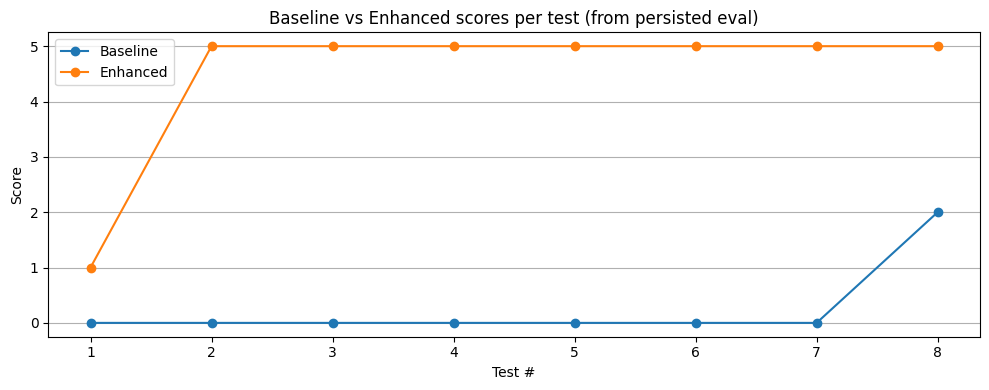

In [13]:
# cell 12 — Line chart using STORED evaluation scores (no recompute)

from pathlib import Path
import json, re
import pandas as pd
import matplotlib.pyplot as plt

runs_dir = Path("./selfrag_runs")

# Prefer explicit globals, else pick latest files
results_csv = Path(LAST_RESULTS_CSV) if 'LAST_RESULTS_CSV' in globals() and Path(LAST_RESULTS_CSV).exists() else None
results_json = Path(LAST_RESULTS_JSON) if 'LAST_RESULTS_JSON' in globals() and Path(LAST_RESULTS_JSON).exists() else None
if results_csv is None:
    cand_csv = sorted(runs_dir.glob("eval_results_*.csv"), key=lambda p: p.stat().st_mtime, reverse=True)
    results_csv = cand_csv[0] if cand_csv else None
if results_json is None:
    cand_json = sorted(runs_dir.glob("eval_results_*.json"), key=lambda p: p.stat().st_mtime, reverse=True)
    results_json = cand_json[0] if cand_json else None

# Load persisted table
if results_csv is not None:
    df = pd.read_csv(results_csv)
    src = str(results_csv)
elif results_json is not None:
    with open(results_json, "r", encoding="utf-8") as f:
        payload = json.load(f)
    df = pd.DataFrame(payload.get("tests", []))
    src = str(results_json)
else:
    raise FileNotFoundError("No saved results found. Run cell 11 first.")

if "index" not in df.columns:
    df["index"] = range(1, len(df) + 1)
df = df.set_index("index")

def _to_int_series(x):
    return pd.to_numeric(x, errors="coerce").astype("Int64")

# Use stored evaluation scores if present; fallback to winner mapping
if {"eval_score_1", "eval_score_2"}.issubset(df.columns):
    baseline_score  = _to_int_series(df["eval_score_1"]).fillna(0)
    enhanced_score  = _to_int_series(df["eval_score_2"]).fillna(0)
else:
    baseline_score = pd.Series(0, index=df.index, dtype="Int64")
    enhanced_score = pd.Series(0, index=df.index, dtype="Int64")

if "eval_best" in df.columns:
    best = _to_int_series(df["eval_best"])
    fill = (baseline_score.isna() | (baseline_score == 0)) & (enhanced_score.isna() | (enhanced_score == 0))
    baseline_score = baseline_score.mask(fill & (best == 1), 1).fillna(0)
    enhanced_score = enhanced_score.mask(fill & (best == 2), 1).fillna(0)

plot_df = pd.DataFrame({
    "query": df.get("query", pd.Series(index=df.index, dtype=str)),
    "mode": df.get("mode", pd.Series(index=df.index, dtype=str)),
    "baseline_score": baseline_score.astype(int),
    "enhanced_score": enhanced_score.astype(int),
})

print("Loaded from:", src)
print(plot_df[["query", "mode", "baseline_score", "enhanced_score"]])

# Plot two lines
plt.figure(figsize=(10, 4))
plt.title("Baseline vs Enhanced scores per test (from persisted eval)")
plt.plot(plot_df.index, plot_df["baseline_score"], marker="o", label="Baseline")
plt.plot(plot_df.index, plot_df["enhanced_score"], marker="o", label="Enhanced")
plt.xlabel("Test #")
plt.ylabel("Score")
plt.xticks(plot_df.index, [str(i) for i in plot_df.index])
plt.grid(True, axis="y")
plt.legend()
plt.tight_layout()
plt.show()

# Keep paths for later reuse
EVAL_RESULTS_SRC = src
